In [1]:
import ReadRawMHD as rR
import mapping as mapp
import numpy as np
import matplotlib.pyplot as plt
import SimpleITK as sitk
import time
import os
t1 = time.time()

In [2]:
# # # # # Input # # # # #
# Input imaging data
model_code = '00_Pilot3'  # FEA model name
sample_code = '00_Pilot3'  # contains number and sample name, e.g. 00_Pilot3.
screw = 'P'  # T or P, site from experiment. Two input files will be generated for each site
file_bone = 'XCT_Icotec_S130672_L5_intact_planned.mhd'  # gray value bone ct scan, gauss filter applied
file_inst = 'ICOTEC_S130672_L5_implants_XCTres.mhd'  # segmented screw scan

In [3]:
# # # # # Input # # # # #
# Input FEA data
file_stl = model_code + '_mesh.stl'
file_dummyMesh = model_code + '_mesh.inp'  # contains nodes and elements
#file_dummyInp = 'Pilot3_mesh.inp'

In [4]:
# Specify file locations
sample_no, sample = sample_code.split('_')  # sample name and number
path_project = '/home/biomech/Documents/01_Icotec/'  # General project folder
path_ct = path_project + '01_Experiments/02_Scans/' + sample + '/04_Registered/'  # Folder of CT data
path_fea = path_project + '02_FEA/99_Tests/' + sample + '/' + sample_code + '/'  # Folder of FEA files
# Include general path for mesh/template later
info = sample + screw + '.txt'  # .txt file containing info about landmarks. Specific structure

In [5]:
# Write mesh input file
mapp.write_mesh(path_fea + sample_code + '_model.inp', path_fea + file_dummyMesh)  # Original input file, path for mesh.inp

Finished extracting mesh file.


In [6]:
# Load data
imD = rR.load_itk(path_ct + file_inst)  # screw image
with open(path_ct + info, 'r') as f:
    content = f.read()
ori = content.split('Origin: ')[1].split('\n')[0]
ori = np.array([int(ori.split(' ')[0]), int(ori.split(' ')[1]), int(ori.split(' ')[2])])
p1P = content.split('positive x axis: ')[1].split('\n')[0]
p1P = np.array([int(p1P.split(' ')[0]), int(p1P.split(' ')[1]), int(p1P.split(' ')[2])])
p1N = content.split('negative x axis: ')[1].split('\n')[0]
p1N = np.array([int(p1N.split(' ')[0]), int(p1N.split(' ')[1]), int(p1N.split(' ')[2])])

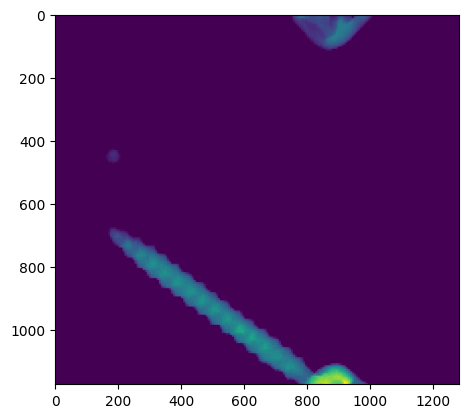

In [7]:
# Plot screws
plt.imshow(np.sum(imD[0], axis=1))  # xray with both screw on it, needed to define ROI for screw axis extraction

In [8]:
# # # # # Input # # # # #
# Define screw vector
v3 = []
if screw == 'T' or screw == '':
    lineT = rR.axis3D(imD[0], 670, 1100, 'x')  # if starting from screw tip towards head, add (-) to v3
    v3 = -lineT.vector  # z-axis = screw axis, found by function. Specify +/-!!
elif screw == 'P':
    lineT = rR.axis3D(imD[0], 0, 600, 'x')  # if starting from screw tip towards head, add (-) to v3
    v3 = lineT.vector  # z-axis = screw axis, found by function. Specify +/-!!
del imD

In [9]:
# Compute matrix
v2 = np.cross(v3, p1P-p1N)/np.linalg.norm(np.cross(v3, p1P-p1N))  # y-axis
v1 = np.cross(v2, v3)  # x-axis
M = np.vstack((np.append(v1, ori[0]), np.append(v2, ori[1]), np.append(v3, ori[2]), np.array([0, 0, 0, 1])))
print(M)

[[-8.69530269e-01  7.30584938e-03 -4.93825613e-01  1.04000000e+02]
 [-1.12854213e-02  9.99335580e-01  3.46559802e-02  4.63000000e+02]
 [ 4.93750696e-01  3.57074539e-02 -8.68870087e-01  7.41000000e+02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]


In [10]:
# Check coordinate system
# z-axis (blue) should point from screw head (origin) towards screw tip (dot)
# y-axis (green) should be perpendicular to screw-rotAxis plane and point upwards (against loading direction)
# x-axis (red): right-handed coordinate system
%matplotlib notebook
plt.figure()
ax = plt.axes(projection='3d')
fact = 100
for i in range(-0, 5):
    ax.scatter3D(ori[0]+i*fact*v1[0], ori[1]+i*fact*v1[1], ori[2]+i*fact*v1[2], c='r', alpha=1)
    ax.scatter3D(ori[0]+i*fact*v2[0], ori[1]+i*fact*v2[1], ori[2]+i*fact*v2[2], c='g', alpha=1)
    ax.scatter3D(ori[0]+i*fact*v3[0], ori[1]+i*fact*v3[1], ori[2]+i*fact*v3[2], c='b', alpha=1)
ax.scatter3D(p1P[0], p1P[1], p1P[2], c='b')
ax.scatter3D([0, 1500], [0, 1500], [0, 1500], alpha=0)
ax.scatter3D(686, 480, 177, c='k', alpha=1)  # Ti tip
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
plt.show()

<IPython.core.display.Javascript object>

In [11]:
bone = {}
stl = path_fea + file_stl

In [12]:
dummyMesh = path_fea + file_dummyMesh

In [13]:
bone = mapp.readInpBoneDummy(bone, dummyMesh)  # Read bone mesh from abaqus. Read elements, nodes

In [14]:
bone = mapp.boneMeshMask(bone, path_fea, stl, 0.0607, sample_code + screw + '_mask.mhd')  # Create mask from abaqus bone mesh

BoneMeshMask


In [15]:
bone = mapp.load_BVTVdata(bone, path_ct + file_bone)

In [16]:
# Read mask
imMask = sitk.ReadImage(path_fea + sample_code + screw + '_mask.mhd')
imMask_np = np.transpose(sitk.GetArrayFromImage(imMask), [2, 1, 0])
bone["GreyImage"].SetOrigin([0, 0, 0])
#im_grey_gauss=sitk.GetImageFromArray(np.transpose(bone['GreyImage'],[2,1,0]))  # save gauss image
#sitk.WriteImage(im_grey_gauss,path_ct + sample_code + 'Gauss.mhd')
# Define rotation and translation
[theta1, theta2, theta3] = rR.rotation_angles_from_matrix(M[:3, :3], 'zyx')
theta2 = -theta2 + np.pi  # +pi because arc-tan no unique solution. WHY NEGATIVE, because mask[:, ::, :] reshaped?
center = np.array([imMask_np.shape[0]/2, imMask_np.shape[1]/2, 0]) * imMask.GetSpacing()
trans = M[:3, 3] * imMask.GetSpacing() - center

In [17]:
# Write transformation file
f = open(path_fea + 'transformation_' + sample_code + screw + '.tfm', "w")
f.write(
    "#Insight Transform File V1.0\n"
    "#Transform 0\n"
    "Transform: CompositeTransform_double_3_3\n"
    "#Transform 1\n"
    "Transform: Euler3DTransform_double_3_3\n"
    "Parameters:  " + f'{theta1}' + " " + f'{theta2}' + " " + f'{theta3}'
    + " " + f'{trans[0]}' + " " + f'{trans[1]}' + " " + f'{trans[2]}' + "\n"  # transformation
    "FixedParameters: " + f'{center[0]}' + " " + f'{center[1]}' + " " + f'{center[2]}' + " 0\n")  # CoR
f.close()

In [18]:
# Apply transformation to mask using the inverse transformation
bone['Transform'] = sitk.ReadTransform(path_fea + 'transformation_' + sample_code + screw + '.tfm')
bone['Transform_inv'] = bone['Transform'].GetInverse()
imMask_trans = sitk.Resample(imMask, bone['GreyImage'], bone['Transform_inv'], sitk.sitkNearestNeighbor, 0.0, bone['GreyImage'].GetPixelID())
# Delete some files / variables to save memory
os.remove(path_fea + sample_code + screw + '_mask.mhd')  #---here mask removing test)
os.remove(path_fea + sample_code + screw + '_mask.raw')  #---here mask removing test)
img_seg=sitk.GetImageFromArray(np.transpose(bone['BVTVscaled'],[2,1,0]))
img_seg.SetOrigin(bone["GreyImage"].GetOrigin())
img_seg.SetSpacing(bone["GreyImage"].GetSpacing())
sitk.WriteImage(img_seg,path_fea+'Test_seg.mhd')
del bone['GreyImage']

In [19]:
# BVTV segmentation / calibration HR-pQCT to uCT
bone['MASK_array_T'] = np.transpose(sitk.GetArrayFromImage(imMask_trans), [2, 1, 0])
# scaling factor/intercept from Schenk et al. 2022, has to be discussed w Ph

In [20]:
elsets = path_fea + sample_code + 'elsets' + screw + '.inp'
materials = path_fea + sample_code +  'materials' + screw + '.inp'
#rR.blockPrint()
mapp.HFE_mapping_trans(bone, elsets, materials)
#rR.enablePrint()

... start material mapping with copying boundary layers as ghost layers
FEelSize material mapping = [3.935514561080886, 3.6360398201413955, 3.934708006807403, 3.6351824073785775, 3.883470532439598, 3.531214064352704, 3.8862862860505585, 3.5280520640627446, 3.8902240193848403, 3.374295830578845, 3.8929979568193933, 3.370837127849245, 4.0964529908189204, 3.0425822174016703, 4.104456186337805, 3.0423523676573714, 3.6456702036175335, 3.9575643358865715, 3.5291458914886347, 3.903720031626939, 3.362074096204058, 3.8980014852795875, 3.025463643748485, 4.089289339061168, 4.156003634675328, 4.229552168685968, 4.212933178054648, 4.319314361898855, 4.411099570828718, 4.450702454676154, 5.155692231118099, 4.637194420169625, 4.225792485091912, 4.22723226319344, 4.146037311204887, 4.154357283068251, 4.317972047124998, 4.317546177765953, 4.208914347726132, 4.211669334326115, 4.451230496760902, 4.445724915652083, 4.414834730692069, 4.401374930768382, 4.640321552211079, 4.628063036570457, 5.17116443438

{'elems': {1: <MedtoolFunctions.med_classes.element at 0x7fcdf71d03d0>,
  2: <MedtoolFunctions.med_classes.element at 0x7fcdf71d0400>,
  3: <MedtoolFunctions.med_classes.element at 0x7fcdf71d0430>,
  4: <MedtoolFunctions.med_classes.element at 0x7fcdf71d0460>,
  5: <MedtoolFunctions.med_classes.element at 0x7fcdf71d0490>,
  6: <MedtoolFunctions.med_classes.element at 0x7fcdf71d04c0>,
  7: <MedtoolFunctions.med_classes.element at 0x7fcdf71d04f0>,
  8: <MedtoolFunctions.med_classes.element at 0x7fcdf71d0520>,
  9: <MedtoolFunctions.med_classes.element at 0x7fcdf71d0550>,
  10: <MedtoolFunctions.med_classes.element at 0x7fcdf71d0580>,
  11: <MedtoolFunctions.med_classes.element at 0x7fcdf71d05b0>,
  12: <MedtoolFunctions.med_classes.element at 0x7fcdf71d05e0>,
  13: <MedtoolFunctions.med_classes.element at 0x7fcdf71d0610>,
  14: <MedtoolFunctions.med_classes.element at 0x7fcdf71d0640>,
  15: <MedtoolFunctions.med_classes.element at 0x7fcdf71d0670>,
  16: <MedtoolFunctions.med_classes.elem

In [21]:
sliceNo = 460
plt.imshow(bone['BVTVscaled'][:, sliceNo, :] + bone['MASK_array_T'][:, sliceNo, :])

plt.show()

In [22]:
# Write final input file
template = path_fea + sample_code + '_model.inp'  # orig is template file
mapp.HFE_inp_creator(template, elsets, materials, path_fea + sample_code + screw + '_P', 'PEEK')
mapp.HFE_inp_creator(template, elsets, materials, path_fea + sample_code + screw + '_T', 'Ti')
# Clean up folder
os.remove(elsets)
os.remove(materials)

Element sets added.
Section set to PEEK.
Material properties added.
End HFE_inp_creator
Element sets added.
Section set to Ti.
Material properties added.
End HFE_inp_creator


In [23]:
print('Execution time: ' + str(int((time.time()-t1)/60)) + ' min '+ str(round(np.mod(time.time()-t1, 60), 1)) + ' sec.')

Execution time: 3 min 33.5 sec.
